In [1]:
import csv
import io
import os
from tensorflow import expand_dims as expand_dimsTF
from skimage.metrics import structural_similarity as ssimSKI
from PIL import Image
import numpy as np
from scripts import commonUtils as alex
%env XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda
import tensorflow as tf
from scripts import commonUtils as alex

# Allow memory growth for the GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

testPool=alex.getSamples("testSet",imgSize=(100,100),batchSize=99999,seed=1,split=0.0)

batch=testPool.getBatch(reshae=False)
paths,_=testPool.returnPaths()

2025-01-28 05:22:12.552252: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-28 05:22:12.572707: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-28 05:22:12.572723: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-28 05:22:12.572727: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-28 05:22:12.576247: I tensorflow/core/platform/cpu_feature_g

env: XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda
Found 86 files belonging to 1 classes.


2025-01-28 05:22:13.755710: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-28 05:22:13.768171: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-28 05:22:13.768274: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

86   86
got another batch,  0  remaning  we are using  86


In [2]:

process_array = lambda x: (np.clip(x,0.0,1.0) * 255).astype(np.uint8)
Image.fromarray(process_array(batch[1])).show()

In [3]:
from modelli import modelli as modelli

model_BW_RGB_50=modelli.AutoencoderFinal(modelli.Autoencoder())

model_BW_RGB_50(batch[:5])
model_BW_RGB_50.load_weights('modelli/BN-RGB-50-RETRAIN.h5')
model_BW_RGB_25=modelli.AutoencoderFinal(modelli.Autoencoder(4),4)

model_BW_RGB_25(batch[:5])
model_BW_RGB_25.load_weights('modelli/BN-RGB-25-RETRAIN.h5')

model_RGB_50=modelli.AutoencoderFinalRGB(modelli.AutoencoderRGB())
model_RGB_50(batch[:5])
model_RGB_50.load_weights('modelli/RGB-25-RETRAIN.h5')

2025-01-28 05:22:14.603633: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902


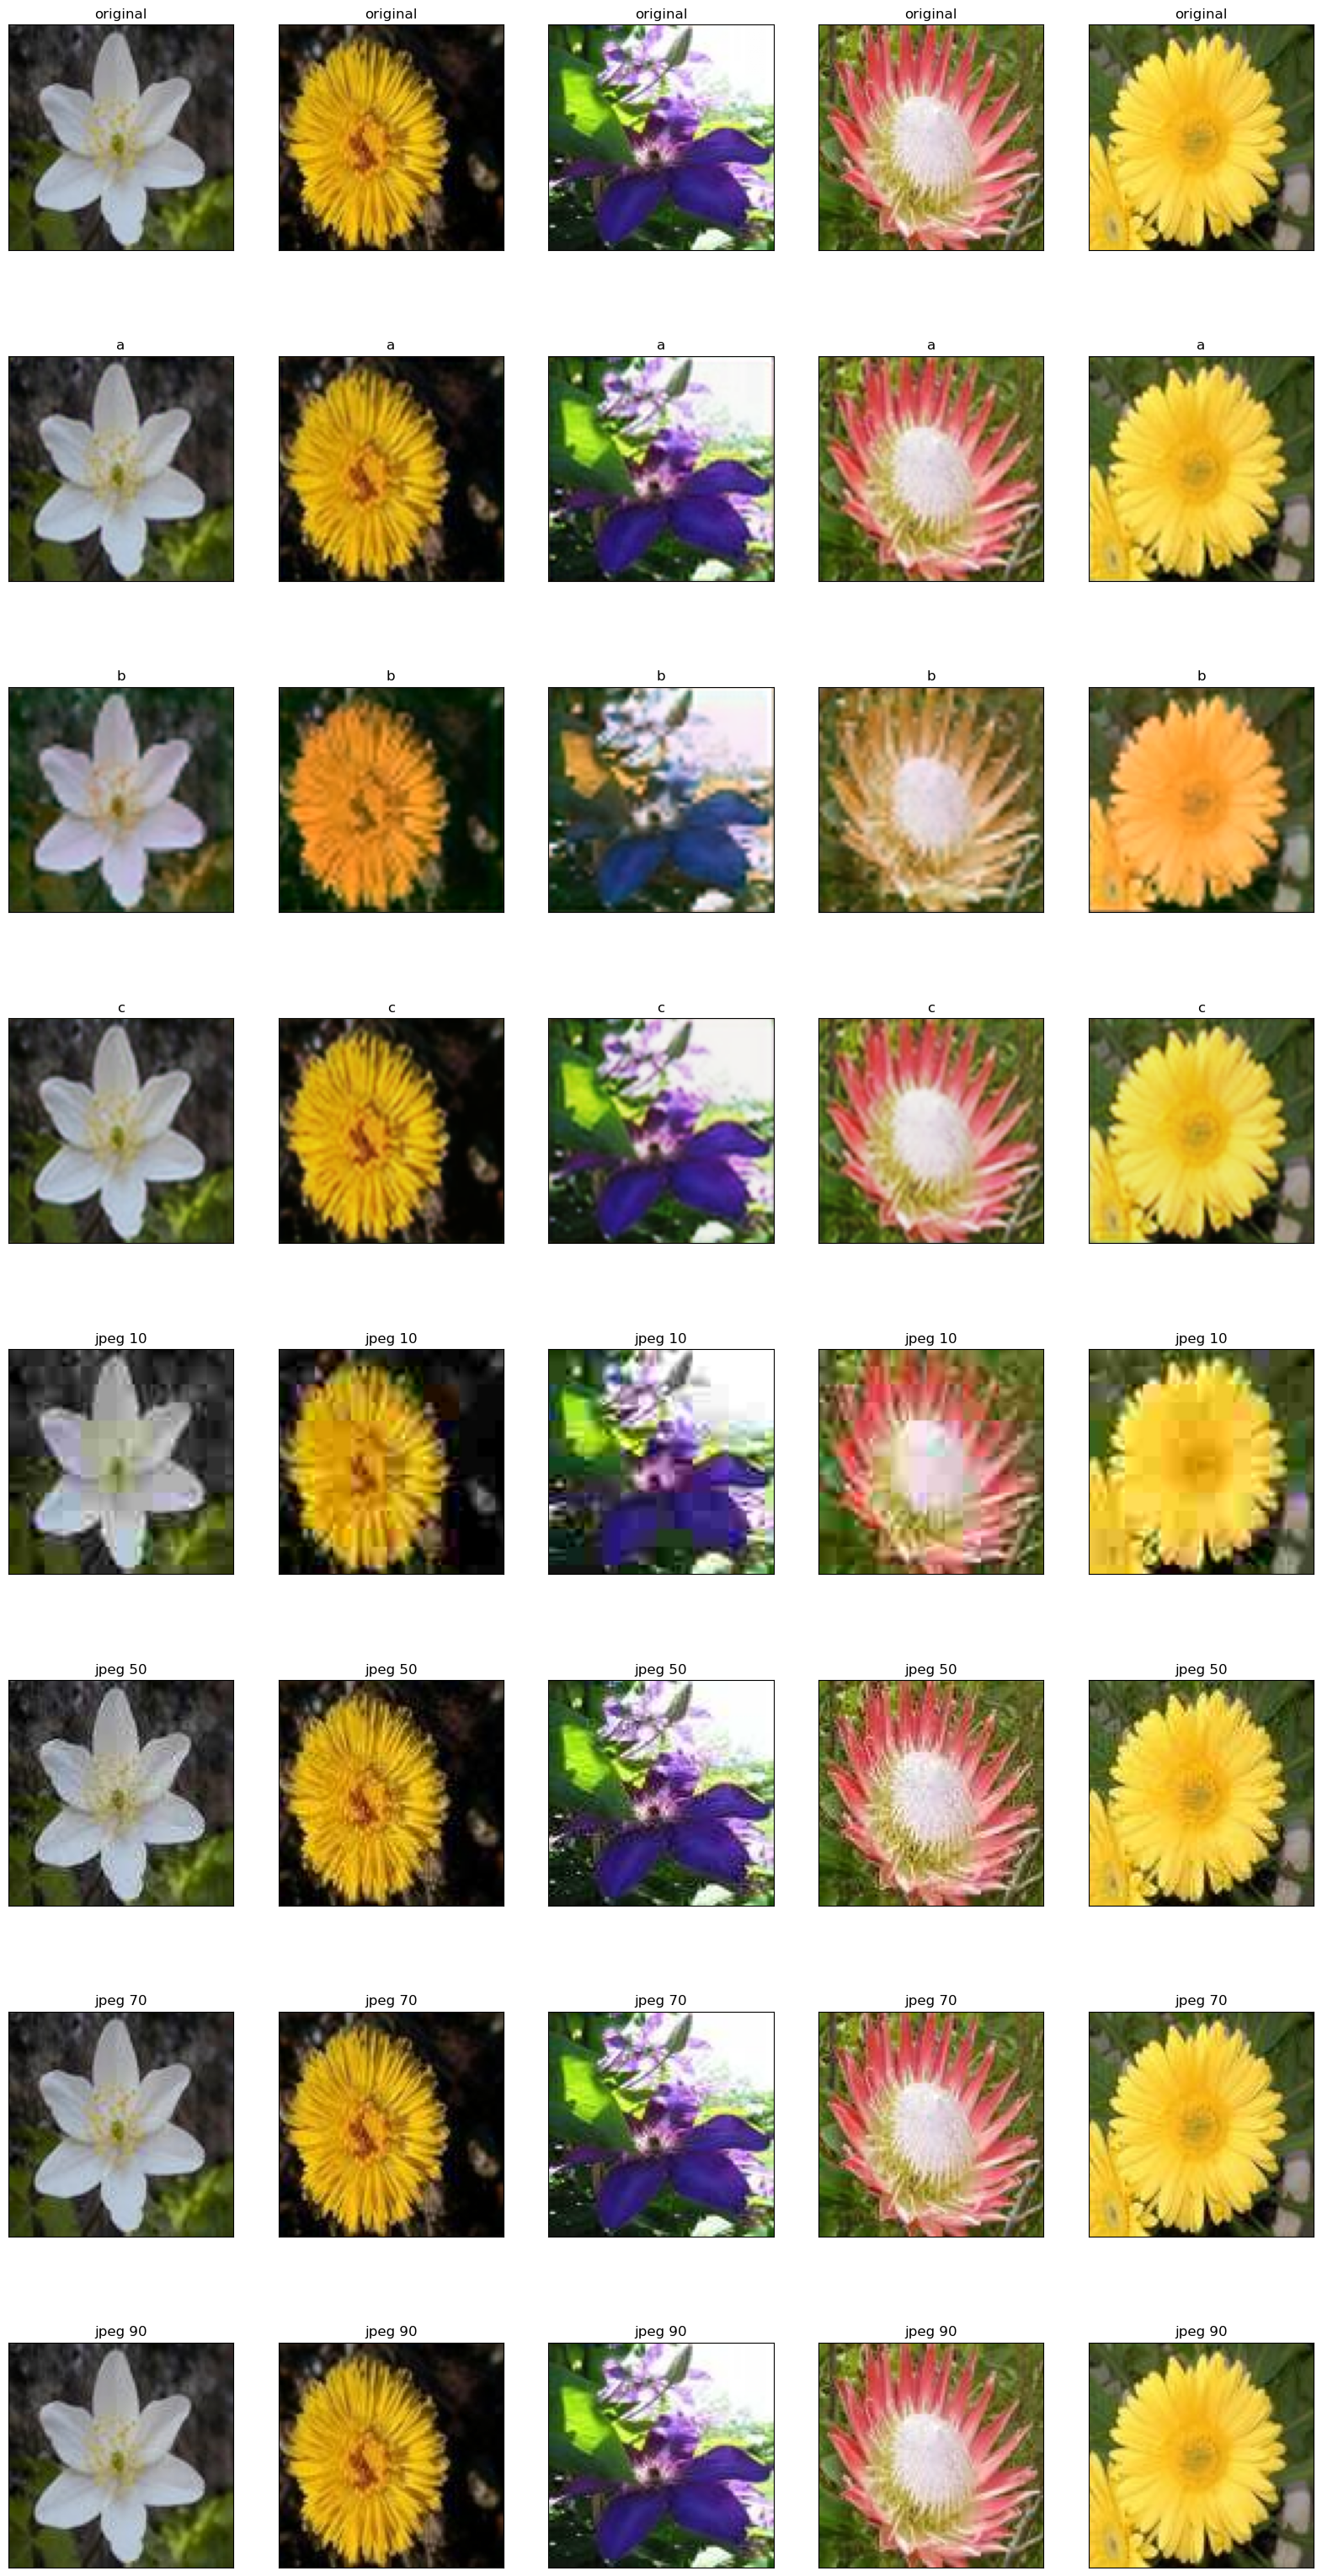

In [4]:
result=alex.prepareImagesOfAllModels([model_BW_RGB_50,model_BW_RGB_25,model_RGB_50],batch[0:5])
alex.printAllDec(batch[0:5],["BW_RGB_50","BW_RGB_25","RGB_50"],result)

In [5]:
model_BW_RGB_50.summary(expand_nested=True)

Model: "autoencoder_final"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        [(None, 50, 50, 1),       172       
                              (None, 50, 50, 3)]                 
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input (InputLayer)         [(None, 100, 100, 3)]     0        |
|                                                               |
| conv2d (Conv2D)            (None, 50, 50, 3)         84       |
|                                                               |
| resizing (Resizing)        (None, 100, 100, 3)       0        |
|                                                               |
| conv2d_1 (Conv2D)          (None, 50, 50, 1)         4        |
|                                                               |
| conv2d_2 (Conv2D)          (None, 50, 50, 3)         84       |
|                                                

In [6]:
"""102flowersresA,resB=model.encoder(batch)
resA=resA.numpy()
resB=resB.numpy()
results=model.converter([resA,resB])
results=model.decoder(results).numpy()
residuals=model.encoder(batch)
for i,res in enumerate(residuals):
        residuals[i]=res.numpy()
print(residuals[0].shape)"""

'102flowersresA,resB=model.encoder(batch)\nresA=resA.numpy()\nresB=resB.numpy()\nresults=model.converter([resA,resB])\nresults=model.decoder(results).numpy()\nresiduals=model.encoder(batch)\nfor i,res in enumerate(residuals):\n        residuals[i]=res.numpy()\nprint(residuals[0].shape)'

In [7]:
#Image.fromarray(process_array(batch[0])).show()

In [8]:
def measure_model_compression_to_csv(image_paths,size ,modelName,model,batch, output_csv):
    results = []
    residuals=model.encoder(batch)
    for i,res in enumerate(residuals):
        residuals[i]=res.numpy()
    residualConverted=model.converter(residuals)
    reconstructed=model.decoder(residualConverted).numpy()
    for i in range(0,len(image_paths)):
            file_size=0
            for j,res in enumerate(residuals):
                if(res.shape[3]==1):
                     image=Image.fromarray(np.squeeze(res[i]), mode='L')
                else:
                     image=Image.fromarray(res[i])
                buffer = io.BytesIO()
                buffer.tell()
                image.save(buffer, format="JPEG", quality=100)
                imageCompressed=Image.open(buffer)
                if(res.shape[3]==1):
                     residuals[j][i]=tf.expand_dims(imageCompressed,axis=-1)
                else:
                     residuals[j][i]=imageCompressed
                buffer.tell()
                file_size += buffer.tell()
            output=model.converter([tf.expand_dims(arr[i], axis=0) for arr in residuals])
            output=model.decoder(output).numpy()
            buffer.close()
            bit_rate=file_size/(size[0]*size[1]*size[2])
            bit_rate=round(bit_rate,5)
            dec= batch[i]
            nor= reconstructed[i]
            media=0
            for j in range(0,3):
                 media+=0.333*tf.image.ssim(tf.constant(np.reshape(dec[:,:,j],(100,100,1)), dtype='float32'), tf.constant(np.reshape(nor[:,:,j],(100,100,1)), dtype='float32'), max_val=1.0).numpy()
            results.append({
                    "image_name": image_paths[i],
                    "name": modelName,
                    "bit_rate": bit_rate,
                    "ssim":media
                })
    with open(output_csv, mode="w+", newline="") as csv_file:
        fieldnames = ["image_name", "name", "bit_rate","ssim"]
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()
        for result in results:
            writer.writerow(result)



def measure_modelRGB_compression_to_csv(image_paths,size ,modelName,model,batch, output_csv):
    results = []
    residuals=model.encoder(batch)
    residuals=residuals.numpy()
    residualConverted=model.converter(residuals)
    reconstructed=model.decoder(residualConverted).numpy()
    for i in range(0,len(batch)):
            file_size=0
            image=Image.fromarray(residuals[i])
            buffer = io.BytesIO()
            buffer.tell()
            image.save(buffer, format="JPEG", quality=100)
            imageCompressed=Image.open(buffer)
            residuals[i]=np.array(imageCompressed)/255
            buffer.tell()
            file_size += buffer.tell()
            output=model.converter(residuals)
            output=model.decoder(output).numpy()
            buffer.close()
            bit_rate=file_size/(size[0]*size[1]*size[2])
            bit_rate=round(bit_rate,5)
            dec= batch[i]
            nor= reconstructed[i]
            media=0
            for j in range(0,3):
                 media+=0.333*tf.image.ssim(tf.constant(np.reshape(dec[:,:,j],(100,100,1)), dtype='float32'), tf.constant(np.reshape(nor[:,:,j],(100,100,1)), dtype='float32'), max_val=1.0).numpy()
            results.append({
                    "image_name": image_paths[i],
                    "name": modelName,
                    "bit_rate": bit_rate,
                    "ssim":media
                })
    with open(output_csv, mode="w+", newline="") as csv_file:
        fieldnames = ["image_name", "name", "bit_rate","ssim"]
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()
        for result in results:
            writer.writerow(result)





measure_model_compression_to_csv(paths,(100,100,3),"BN-RGB-50",model_BW_RGB_50,batch,"bn-rgb-50_results.csv")
measure_model_compression_to_csv(paths,(100,100,3),"BN-RGB-25",model_BW_RGB_25,batch,"bn-rgb-25_results.csv")
measure_modelRGB_compression_to_csv(paths,(100,100,3),"RGB-50",model_RGB_50,batch,"rgb-50_results.csv")


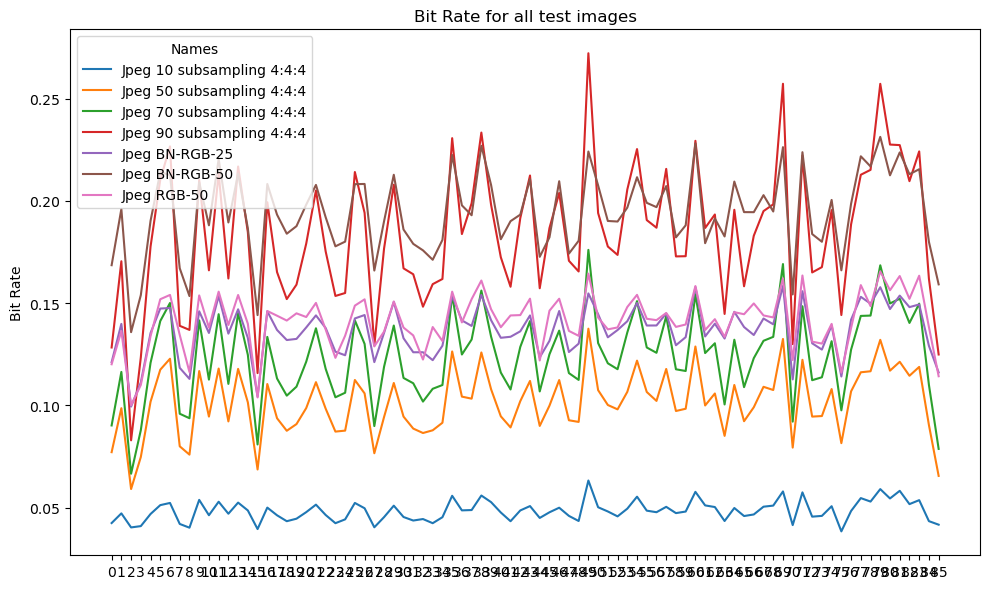

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
output_csv = ["compression_results.csv","bn-rgb-50_results.csv","bn-rgb-25_results.csv","rgb-50_results.csv"]  # Path to the output CSV file
data=None
for inx,x in enumerate(output_csv):
    if inx==0:
        data = pd.read_csv(x)
    else:
        data=pd.concat([data, pd.read_csv(x)], ignore_index=True)

data.head()
pivot_table = data.pivot_table(index="image_name", columns="name", values="bit_rate")
plt.figure(figsize=(10, 6))

for quality in pivot_table.columns:
    plt.plot(pivot_table.index, pivot_table[quality], label=f"Jpeg {quality}")

plt.xlabel("")
plt.ylabel("Bit Rate")
plt.title("Bit Rate for all test images")
plt.legend(title="Names")
plt.grid(False)

plt.xticks(ticks=range(len(pivot_table.index)), labels=range(len(pivot_table.index)))

# Show the plot
plt.tight_layout()
plt.show()

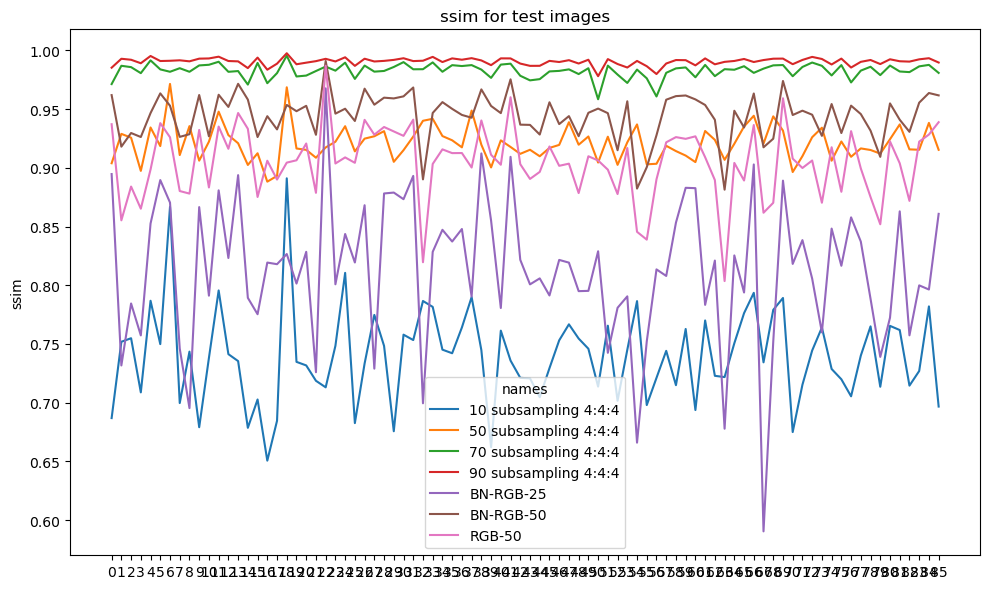

In [10]:
group_size = 1  
data["group_index"] = data.groupby("name").cumcount() // group_size

grouped_data = data.groupby(["group_index", "name"])["ssim"].mean().reset_index()

pivot_table = grouped_data.pivot(index="group_index", columns="name", values="ssim")
plt.figure(figsize=(10, 6))
for quality in pivot_table.columns:
    plt.plot(pivot_table.index, pivot_table[quality], label=f"{quality}")

plt.xlabel("")
plt.ylabel("ssim")
plt.title("ssim for test images")
plt.legend(title="names")
plt.grid(False)

plt.xticks(ticks=range(len(pivot_table.index)), labels=range(len(pivot_table.index)))

plt.tight_layout()
plt.show()

In [11]:
import numpy as np
data["new_met"]=(1-data["bit_rate"])*data["ssim"]
# data["new_met"]=np.where(data["ssim"]>0.80, (1-data["bit_rate"])*(data["ssim"]), (1-data["bit_rate"])*(pow(data["ssim"],2)))

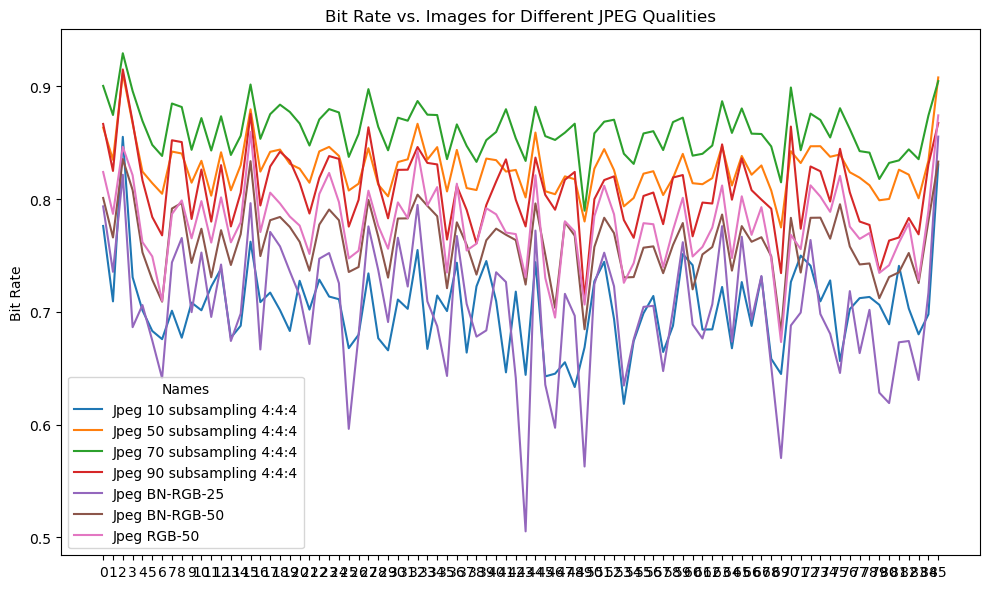

In [12]:
# Iterate over each quality level and plot a line
pivot_table = data.pivot_table(index="image_name", columns="name", values="new_met")
plt.figure(figsize=(10, 6))

for quality in pivot_table.columns:
    plt.plot(pivot_table.index, pivot_table[quality], label=f"Jpeg {quality}")

# Add labels and legend
plt.xlabel("")
plt.ylabel("Bit Rate")
plt.title("Bit Rate vs. Images for Different JPEG Qualities")
plt.legend(title="Names")
plt.grid(False)

# Replace x-axis labels with indices
plt.xticks(ticks=range(len(pivot_table.index)), labels=range(len(pivot_table.index)))

# Show the plot
plt.tight_layout()
plt.show()